<a href="https://colab.research.google.com/github/Hrishkesh/Invoice-/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --user tensorflow-gpu==2.0.0 -q

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!mkdir -p models

In [7]:
!unzip /content/drive/My\ Drive/eng_500_epochs -d /content/models/

Archive:  /content/drive/My Drive/eng_500_epochs
   creating: /content/models/content/data/output/
   creating: /content/models/content/data/output/.ipynb_checkpoints/
   creating: /content/models/content/data/output/models/
  inflating: /content/models/content/data/output/models/model__epoch_51_10.134.ckpt.data-00000-of-00001  
  inflating: /content/models/content/data/output/models/model__epoch_11_635.9874.ckpt.data-00000-of-00001  
  inflating: /content/models/content/data/output/models/model__epoch_201_1.7976.ckpt.index  
  inflating: /content/models/content/data/output/models/model__epoch_261_1.0315.ckpt.index  
  inflating: /content/models/content/data/output/models/model__epoch_71_16.0339.ckpt.index  
  inflating: /content/models/content/data/output/models/model__epoch_81_4.2419.ckpt.data-00000-of-00001  
  inflating: /content/models/content/data/output/models/checkpoint  
  inflating: /content/models/content/data/output/models/model__epoch_291_1.0271.ckpt.data-00000-of-00001  


In [8]:
width = 128
height = 256
input_channels = 61
base_channels = 64
learning_rate = 0.05
momentum = 0.9
weight_decay = 0.1
spatial_dropout = 0.1
nb_classes = 5
nb_anchors = 4 # one per foreground class
proba_classes = np.array([0.89113252, 0.0113842, 0.0502577, 0.03224928, 0.0149763]) #other, total, address, company, date
constant_weight = 1.04

In [9]:
class Network(tf.keras.Model):
    def __init__(self):
        super(Network, self).__init__()
        ## Block z
        self.z1 = tf.keras.layers.Conv2D(input_shape=(None, height, width, input_channels), filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.z1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.z1_bn = tf.keras.layers.BatchNormalization()

        self.z2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.z2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.z2_bn = tf.keras.layers.BatchNormalization()
        
        self.z3 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.z3_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.z3_bn = tf.keras.layers.BatchNormalization()
        
        self.z4 = tf.keras.layers.Dropout(rate=spatial_dropout)
        
        ## Block a
        self.a1 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.a1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.a1_bn = tf.keras.layers.BatchNormalization()

        self.a2 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.a2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.a2_bn = tf.keras.layers.BatchNormalization()
        
        self.a3 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.a3_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.a3_bn = tf.keras.layers.BatchNormalization()
        
        self.a4 = tf.keras.layers.Dropout(rate=spatial_dropout)


        ## Block a_bis
        self.a_bis_filters = [4*base_channels, 8*base_channels, 8*base_channels]
        self.a_bis_stride = [2, 2, 1]
        self.a_bis_dilatation = [2, 4, 8]
        
        self.a_bis1 = []
        self.a_bis1_lrelu = []
        self.a_bis1_bn = []
        
        self.a_bis2 = []
        self.a_bis2_lrelu = []
        self.a_bis2_bn = []
        
        self.a_bis3 = []
        self.a_bis3_lrelu = []
        self.a_bis3_bn = []
        
        self.a_bis4 = []
        
        for i in range(0, len(self.a_bis_filters)):
            self.a_bis1.append(tf.keras.layers.Conv2D(filters=self.a_bis_filters[i], kernel_size=3, strides=self.a_bis_stride[i], padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.a_bis1_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.a_bis1_bn.append(tf.keras.layers.BatchNormalization())

            self.a_bis2.append(tf.keras.layers.Conv2D(filters=self.a_bis_filters[i], kernel_size=3, strides=1, dilation_rate=self.a_bis_dilatation[i], padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.a_bis2_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.a_bis2_bn.append(tf.keras.layers.BatchNormalization())
        
            self.a_bis3.append(tf.keras.layers.Conv2D(filters=self.a_bis_filters[i], kernel_size=3, strides=1, dilation_rate=self.a_bis_dilatation[i], padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.a_bis3_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.a_bis3_bn.append(tf.keras.layers.BatchNormalization())
        
            self.a_bis4.append(tf.keras.layers.Dropout(rate=spatial_dropout))
        
        
        ## Block b_ss (semantic segmentation)
        self.b_ss_filters = [4*base_channels, 2*base_channels]
        
        self.b_ss1 = []
        self.b_ss1_lrelu = []
        self.b_ss1_bn = []
        
        self.b_ss2 = []
        self.b_ss2_lrelu = []
        self.b_ss2_bn = []
        
        self.b_ss3 = []
        self.b_ss3_lrelu = []
        self.b_ss3_bn = []
        
        self.b_ss4 = []
        self.b_ss4_lrelu = []
        self.b_ss4_bn = []
        
        self.b_ss5 = []
        
        for i in range(0, len(self.b_ss_filters)):
            self.b_ss1.append(tf.keras.layers.Conv2D(filters=2*self.b_ss_filters[i], kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss1_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss1_bn.append(tf.keras.layers.BatchNormalization())

            self.b_ss2.append(tf.keras.layers.Conv2DTranspose(filters=self.b_ss_filters[i], kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss2_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss2_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_ss3.append(tf.keras.layers.Conv2D(filters=self.b_ss_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss3_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss3_bn.append(tf.keras.layers.BatchNormalization())
            
            self.b_ss4.append(tf.keras.layers.Conv2D(filters=self.b_ss_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss4_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss4_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_ss5.append(tf.keras.layers.Dropout(rate=spatial_dropout))
        
        
        ## Block b_bbr (bounding box regression)
        self.b_bbr_filters = [4*base_channels, 2*base_channels]
        
        self.b_bbr1 = []
        self.b_bbr1_lrelu = []
        self.b_bbr1_bn = []
        
        self.b_bbr2 = []
        self.b_bbr2_lrelu = []
        self.b_bbr2_bn = []
        
        self.b_bbr3 = []
        self.b_bbr3_lrelu = []
        self.b_bbr3_bn = []
        
        self.b_bbr4 = []
        self.b_bbr4_lrelu = []
        self.b_bbr4_bn = []
        
        self.b_bbr5 = []
        
        for i in range(0, len(self.b_bbr_filters)):
            self.b_bbr1.append(tf.keras.layers.Conv2D(filters=2*self.b_bbr_filters[i], kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr1_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr1_bn.append(tf.keras.layers.BatchNormalization())

            self.b_bbr2.append(tf.keras.layers.Conv2DTranspose(filters=self.b_bbr_filters[i], kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr2_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr2_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_bbr3.append(tf.keras.layers.Conv2D(filters=self.b_bbr_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr3_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr3_bn.append(tf.keras.layers.BatchNormalization())
            
            self.b_bbr4.append(tf.keras.layers.Conv2D(filters=self.b_bbr_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr4_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr4_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_bbr5.append(tf.keras.layers.Dropout(rate=spatial_dropout))
        
        
        ## Block c_ss
        self.c_ss1 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_ss1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_ss1_bn = tf.keras.layers.BatchNormalization()

        self.c_ss2 = tf.keras.layers.Conv2DTranspose(filters=base_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_ss2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_ss2_bn = tf.keras.layers.BatchNormalization()
        
        
        ## Block c_bbr
        self.c_bbr1 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_bbr1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_bbr1_bn = tf.keras.layers.BatchNormalization()

        self.c_bbr2 = tf.keras.layers.Conv2DTranspose(filters=base_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_bbr2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_bbr2_bn = tf.keras.layers.BatchNormalization()
        
        
        ## Block d
        self.d1 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.d1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.d1_bn = tf.keras.layers.BatchNormalization()

        self.d2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.d2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.d2_bn = tf.keras.layers.BatchNormalization()
        
        self.d3 = tf.keras.layers.Conv2D(filters=nb_classes, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.constant_initializer(value=1e-3), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.d3_softmax = tf.keras.layers.Softmax()
        
        
        ## Block e
        self.e1 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.e1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.e1_bn = tf.keras.layers.BatchNormalization()

        self.e2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.e2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.e2_bn = tf.keras.layers.BatchNormalization()
        
        self.e3 = tf.keras.layers.Conv2D(filters=2*nb_anchors, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.constant_initializer(value=1e-3), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.e3_softmax = tf.keras.layers.Softmax()
        
        
        ## Block f
        self.f1 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.f1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.f1_bn = tf.keras.layers.BatchNormalization()

        self.f2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.f2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.f2_bn = tf.keras.layers.BatchNormalization()
        
        self.f3 = tf.keras.layers.Conv2D(filters=4*nb_anchors, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.constant_initializer(value=1e-3), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))


    def call(self, input):
        ## Input shape 256, 128, 61
        ## 61 channels because 61 significant characters out of 93 distinct characters
        ## Encoder
        x = self.z1(input) ## 256, 128, 64
        x = self.z1_lrelu(x) ## 256, 128, 64
        x = self.z1_bn(x) ## 256, 128, 64
        x = self.z2(x)  ## 256, 128, 64
        x = self.z2_lrelu(x)
        x = self.z2_bn(x)
        x = self.z3(x)
        x = self.z3_lrelu(x)
        x = self.z3_bn(x)
        out_z = self.z4(x)  ## 256, 128, 64
        
        x = self.a1(out_z)
        x = self.a1_lrelu(x)
        x = self.a1_bn(x)
        x = self.a2(x)
        x = self.a2_lrelu(x)
        x = self.a2_bn(x)
        x = self.a3(x)
        x = self.a3_lrelu(x)
        x = self.a3_bn(x)
        out_a = self.a4(x)  # 128, 64, 128
        
        out_a_bis = []  # [(64 , 32 , 256), (32, 16, 512), (32, 16, 512)]
        x = out_a
        for i in range(0, len(self.a_bis_filters)):
            x = self.a_bis1[i](x)
            x = self.a_bis1_lrelu[i](x)
            x = self.a_bis1_bn[i](x)
            x = self.a_bis2[i](x)
            x = self.a_bis2_lrelu[i](x)
            x = self.a_bis2_bn[i](x)
            x = self.a_bis3[i](x)
            x = self.a_bis3_lrelu[i](x)
            x = self.a_bis3_bn[i](x)
            x = self.a_bis4[i](x)
            out_a_bis.append(x)  
        
        ## Decoder Semantic Segmentation
        concat_tab = [out_a_bis[1], out_a_bis[0]]  # Why 0 and 1?
        for i in range(0, len(self.b_ss_filters)):
            x = tf.concat([x, concat_tab[i]], 3)
            x = self.b_ss1[i](x)
            x = self.b_ss1_lrelu[i](x)
            x = self.b_ss1_bn[i](x)
            x = self.b_ss2[i](x)
            x = self.b_ss2_lrelu[i](x)
            x = self.b_ss2_bn[i](x)
            x = self.b_ss3[i](x)
            x = self.b_ss3_lrelu[i](x)
            x = self.b_ss3_bn[i](x)
            x = self.b_ss4[i](x)
            x = self.b_ss4_lrelu[i](x)
            x = self.b_ss4_bn[i](x)
            x = self.b_ss5[i](x)

        ## 128, 64, 128
        
        x = tf.concat([x, out_a], 3)
        x = self.c_ss1(x)
        x = self.c_ss1_lrelu(x)
        x = self.c_ss1_bn(x)
        x = self.c_ss2(x)
        x = self.c_ss2_lrelu(x)
        x = self.c_ss2_bn(x)
        
        x = self.d1(x)
        x = self.d1_lrelu(x)
        x = self.d1_bn(x)
        x = self.d2(x)
        x = self.d2_lrelu(x)
        x = self.d2_bn(x)
        x = self.d3(x)
        out_d = self.d3_softmax(x)  ## 256, 128, 5
        
        ## Decoder Bounding Box Regression
        concat_tab = [out_a_bis[1], out_a_bis[0]]
        x = out_a_bis[-1]
        for i in range(0, len(self.b_bbr_filters)):
            x = tf.concat([x, concat_tab[i]], 3)
            x = self.b_bbr1[i](x)
            x = self.b_bbr1_lrelu[i](x)
            x = self.b_bbr1_bn[i](x)
            x = self.b_bbr2[i](x)
            x = self.b_bbr2_lrelu[i](x)
            x = self.b_bbr2_bn[i](x)
            x = self.b_bbr3[i](x)
            x = self.b_bbr3_lrelu[i](x)
            x = self.b_bbr3_bn[i](x)
            x = self.b_bbr4[i](x)
            x = self.b_bbr4_lrelu[i](x)
            x = self.b_bbr4_bn[i](x)
            x = self.b_bbr5[i](x)
        
        x = tf.concat([x, out_a], 3)
        x = self.c_bbr1(x)
        x = self.c_bbr1_lrelu(x)
        x = self.c_bbr1_bn(x)
        x = self.c_bbr2(x)
        x = self.c_bbr2_lrelu(x)
        out_c_bbr = self.c_bbr2_bn(x)
        
        x = self.e1(out_c_bbr)
        x = self.e1_lrelu(x)
        x = self.e1_bn(x)
        x = self.e2(x)
        x = self.e2_lrelu(x)
        x = self.e2_bn(x)
        x = self.e3(x)
        out_e = self.e3_softmax(x)
        
        x = self.f1(out_c_bbr)
        x = self.f1_lrelu(x)
        x = self.f1_bn(x)
        x = self.f2(x)
        x = self.f2_lrelu(x)
        x = self.f2_bn(x)
        out_f = self.f3(x)
        
        return out_d, out_e, out_f ## out_d --> (256,128,5), out_e --> (256, 128, 8) , out_f --> (256, 128, 16)


In [10]:
net = Network()

In [12]:
net.load_weights('/content/models/content/data/output/models/model__epoch_231_0.9.ckpt.index')

In [13]:
def get_class_weights():
    sample_weight_seg = np.ones((height, width, nb_classes))*1.0/np.log(constant_weight+proba_classes)

    proba_classes_boxmask = np.repeat(proba_classes[1:], 2)
    proba_classes_boxmask[np.arange(1, 2*nb_anchors, 2)] = 1-proba_classes[1:]
    sample_weight_boxmask = np.ones((height, width, 2*nb_anchors))*1.0/np.log(constant_weight+proba_classes_boxmask)
    
    return sample_weight_seg, sample_weight_boxmask

In [15]:
sample_weight_seg, sample_weight_boxmask = get_class_weights()

In [16]:
losses = {'output_1': tf.keras.losses.BinaryCrossentropy(), 'output_2': tf.keras.losses.BinaryCrossentropy(), 'output_3': tf.keras.losses.Huber()}
metrics = {'output_1': tf.keras.metrics.MeanIoU(num_classes=5), 'output_2': tf.keras.metrics.CategoricalAccuracy(), 'output_3': tf.keras.metrics.CategoricalAccuracy()}
sample_weights = {'output_1': sample_weight_seg, 'output_2': sample_weight_boxmask}

net.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False), loss=losses, metrics=metrics, sample_weight=sample_weights)

In [ ]:
!wget https://www.dropbox.com/s/4clhp03dlcp47ov/Test.zip

In [18]:
!mkdir -p data

In [ ]:
!unzip Test.zip -d /content/data/

In [20]:
import glob
import random
import numpy as np

In [21]:
input_files = glob.glob('/content/data/Outdir_np_chargrid_1h/*')

In [22]:
index = random.randint(0,len(input_files)-1)

In [23]:
input = np.expand_dims(np.load(input_files[index]), axis=0)

In [24]:
input.shape

(1, 256, 128, 61)

In [25]:
 y_hat = net.predict(input)

In [ ]:
for i in range

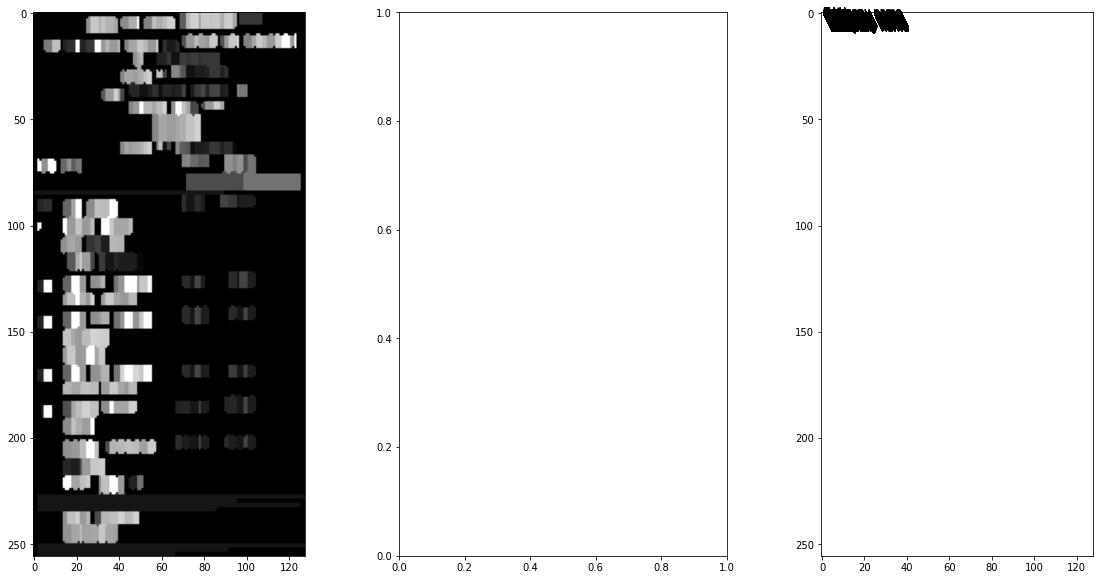

In [26]:
class_mapping = {
                0 : 'Total', 
                1 : 'Address', 
                2 : 'Company name', 
                3 : 'Date'
} 
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(np.argmax(input[0], axis=2), cmap='gray')
#ax[1].imshow(np.argmax(y_hat[0][0], axis=2), cmap='gray')
white = np.zeros([input[0].shape[0], input[0].shape[1],3],dtype=np.uint8)
white.fill(255)
ax[2].imshow(white)
for i in range(0, y_hat[2][0].shape[0]):
  for j in range(0, y_hat[2][0].shape[1]):
    if (np.sum(y_hat[2][0][i][j])==0):
      continue
    # print(batch_coord[1][i][j])
    for k in range(0, 4):
      left = y_hat[2][0][i][j][4*k] * width
      top = y_hat[2][0][i][j][4*k+1] * height
      right = y_hat[2][0][i][j][4*k+2] * width
      bottom = y_hat[2][0][i][j][4*k+3] * height
      rect1 = patches.Rectangle((left, top),
                        (right - left),
                        (bottom - top),
                        linewidth=1,edgecolor='r',facecolor='none')
      ax[2].add_patch(rect1)
      ax[2].text(left + (right - left),top,class_mapping[k]) 
plt.show()
